# Data-driven Biogas Model of the Anaerobic Digester

## Preamble

In [1]:
# Here all the required packages are loaded
import numpy as np
import os
import pandas as pd
from pymatreader import read_mat
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
import dill
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVR
from hypopt import GridSearch
import seaborn as sns
from sklearn.linear_model import Ridge
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import tree
from scipy import stats
import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import widgets, interactive, interact

## Loading and preparation of the data

First we load the data from a local directory.

The data is available from my Google drive at:
https://drive.google.com/file/d/183sbF1tTeYw0HyxDqr-7paquMeNOuLp2/view?usp=sharing

In [2]:
# Redirect to the directory where the file is located
directory = '/Users/Sebastian/Documents/Leif/DTU/Speciale/Runs'
os.chdir(directory)

# Load the file with the pymatreader function read_mat
data_mat = read_mat('Data.mat')

Second we need to create dataframes with the proper labeling where we can load the different data-sets. The data file includes matrices for both the effluent and biogas modelling, however for this notebook we will focus on the biogas modelling.

In [3]:
# Defining column names
# Variable names for the first biogas model that takes its input from the influent
# to the anaerobic digester
Header_X_in = ['Q', 'T', 'TSS', r'$\mathbf{NH_4}$', r'$\mathbf{PO^{3-}_4}$', r'$\mathbf{CO^{2-}_3}$', r'$\mathbf{CH_3COO^-}$','pH']

# Variable names for the second biogas model that takes its input from the effluent
# of the anaerobic digester
Header_X_out = ['Q', 'T', 'TSS', r'$\mathbf{NH_4}$', r'$\mathbf{PO^{3-}_4}$', r'$\mathbf{CO^{2-}_3}$','pH', 'VFAs']

# Variable names for the outputs of the biogas model. The variables that we are trying to predict.
Header_y  = ['Biogas', r'$\mathbf{CH_{4}\%}$']

In [4]:
# Creating a Pandas dataframe for the 3 data sets.
X_in = pd.DataFrame(data_mat['Digester_in_X'], columns = Header_X_in)
X_out = pd.DataFrame(data_mat['Digester_out_X'], columns = Header_X_out)
y = pd.DataFrame(data_mat['Digester_out_y'], columns = Header_y)

In [5]:
X_out.head()

,Q,T,TSS,$\mathbf{NH_4}$,$\mathbf{PO^{3-}_4}$,$\mathbf{CO^{2-}_3}$,pH,VFAs
0,166.438516,34.998207,18.934344,0.078775,0.029849,0.097082,7.066074,0.085204
1,160.293246,34.860240,18.936363,0.078730,0.029797,0.097028,7.069055,0.085956
2,156.428981,34.824238,19.095540,0.078540,0.029889,0.096329,7.054566,0.085612
3,151.866885,35.037037,19.076301,0.078693,0.029959,0.096485,7.080834,0.085533
4,148.082973,35.013577,19.020382,0.078773,0.029807,0.096284,7.089877,0.085758


In [6]:
y.head()

,Biogas,$\mathbf{CH_{4}\%}$
0,2464.082386,0.599330
1,2467.376193,0.598718
2,2462.682931,0.601654
3,2467.473130,0.600771
4,2467.189069,0.597209


We now split the data into training and test data. We are not shuffling the data, since we are doing time-series modelling further on, and the data hasn't been ordered in anyway apart from by time.

In [7]:
X_in_train, X_in_test, X_out_train, X_out_test, y_train, y_test = train_test_split(X_in, X_out, y, test_size = 0.2, shuffle = False)

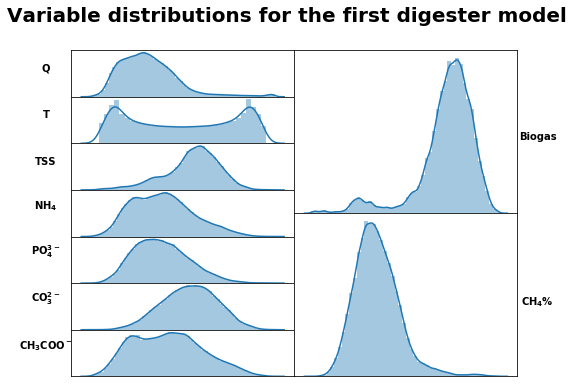

In [8]:
# Creating a visual overview of the different distributions
fig = plt.figure(figsize=(8, 6))

fig.suptitle('Variable distributions for the first digester model', fontsize = 20, fontweight = 'bold')

ax1= fig.add_subplot(7,2,1)
ax2= fig.add_subplot(7,2,3)
ax3= fig.add_subplot(7,2,5)
ax4= fig.add_subplot(7,2,7)
ax5= fig.add_subplot(7,2,9)
ax6= fig.add_subplot(7,2,11)
ax7= fig.add_subplot(7,2,13)
ax8 = fig.add_subplot(2,2,2)
ax9 = fig.add_subplot(2,2,4)
fig.subplots_adjust(hspace = 0, wspace = 0)

axfull = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(axfull)):
    axfull[i].set_xticks([])
    axfull[i].set_yticks([])
    axfull[i].xaxis.set_visible(False)
    

for i in range(7):
    sns.distplot(X_in[Header_X_in[i]], ax = axfull[i])
    axfull[i].set_ylabel(Header_X_in[i], rotation = 0, labelpad = 25, fontweight = 'bold')

sns.distplot(y[Header_y[0]], ax = ax8)
ax8.set_ylabel(Header_y[0], rotation = 0, labelpad = 20, fontweight = 'bold')
ax8.yaxis.set_label_position('right')
sns.distplot(y[Header_y[1]], ax = ax9)
ax9.set_ylabel(Header_y[1], rotation = 0, labelpad = 20, fontweight = 'bold')
ax9.yaxis.set_label_position('right')

ax7.set_xlabel('')
ax9.set_xlabel('')

plt.show()

We can now fit a few data-driven models to the data.

In [9]:
class CVMethod:
    def __init__(self, X_train, y_train, X_test, y_test, param_dict, Method):
        self.pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('clf', Method)
        ])
        
        self.param_grid = param_dict
        self.grid = GridSearchCV(self.pipeline, param_grid = self.param_grid, cv = 3, verbose = False, n_jobs = -1)
        
        self.grid.fit(X_train, y_train)
        self.predictions = self.grid.predict(X_test)
        self.residuals = y_test - self.predictions.ravel()
        self.RMSE = np.mean((self.residuals)**2)**0.5

In [10]:
class Different_variables:
    def __init__(self, X_train, X_test, param_dict, Method):
        self.Biogas = CVMethod(X_train, y_train['Biogas'], X_test, y_test['Biogas'], param_dict, Method)
        self.CH4 = CVMethod(X_train, y_train[r'$\mathbf{CH_{4}\%}$'], X_test, y_test[r'$\mathbf{CH_{4}\%}$'], param_dict, Method)

In [11]:
class Different_methods:
    def __init__(self, X_train, X_test):
        self.linreg = Different_variables(X_train, X_test, param_linreg, LinearRegression())
        self.PLS = Different_variables(X_train, X_test, param_PLS, PLSRegression())
        self.KNN = Different_variables(X_train, X_test, param_KNN, KNeighborsRegressor())
        self.RF = Different_variables(X_train, X_test, param_RF, RandomForestRegressor())

In [12]:
param_linreg = {}
param_PLS = {'clf__n_components':  [int(x) for x in np.linspace(1,8,8)]}
param_KNN = {'clf__n_neighbors': [int(x) for x in np.linspace(2,150,149)]}
param_RF = {
    'clf__n_estimators': [int(x) for x in np.logspace(1,10,num = 10, base = 2)],
    'clf__max_features': [int(x) for x in np.linspace(1,8,8)]
}

In [13]:
In_model = Different_methods(X_in_train, X_in_test)

In [14]:
Out_model = Different_methods(X_out_train, X_out_test)

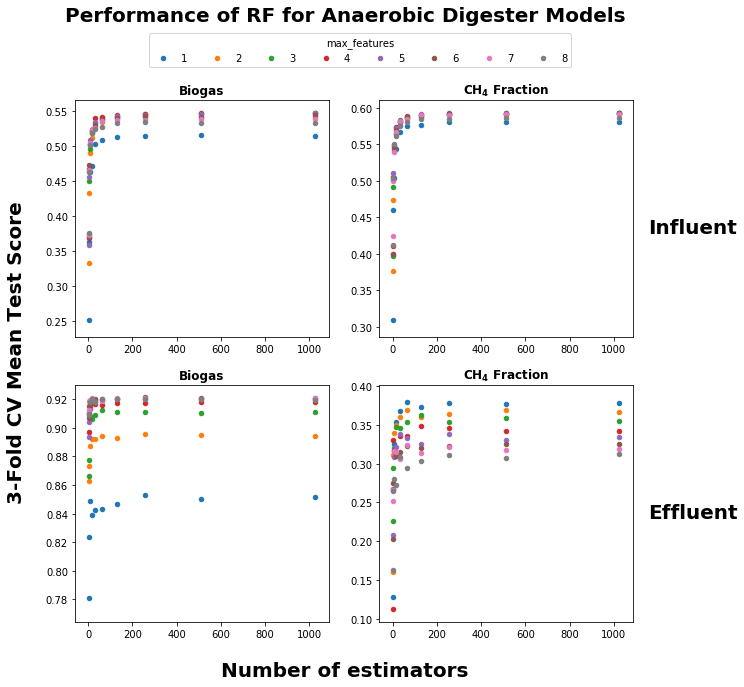

In [74]:
#RF Comparison
n_estimators = [int(x) for x in np.logspace(1,10,num = 10, base = 2)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of RF for Anaerobic Digester Models', fontsize = 20, fontweight = 'bold')


for i in range(8):
    ax[0].scatter(n_estimators,In_model.RF.Biogas.grid.cv_results_['mean_test_score'][i*10:(i*10+10)], s = 20)
    ax[1].scatter(n_estimators,In_model.RF.CH4.grid.cv_results_['mean_test_score'][i*10:(i*10+10)], s = 20)

for i in range(8):
    ax[2].scatter(n_estimators,Out_model.RF.Biogas.grid.cv_results_['mean_test_score'][i*10:(i*10+10)], s = 20)
    ax[3].scatter(n_estimators,Out_model.RF.CH4.grid.cv_results_['mean_test_score'][i*10:(i*10+10)], s = 20)

titles = ['Biogas', r'$\mathbf{CH_4}$ Fraction', 'Biogas', r'$\mathbf{CH_4}$ Fraction']    
legends = [int(x) for x in np.linspace(1,8,8)] 
legend_properties = {'weight':'bold'}

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

ax[1].set_ylabel('Influent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[1].yaxis.set_label_position('right')
ax[3].set_ylabel('Effluent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[3].yaxis.set_label_position('right')

fig.text(0.031, 0.5,'3-Fold CV Mean Test Score', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of estimators', ha = 'center', fontsize = 20, fontweight = 'bold')

fig.legend(legends,
          loc = "upper center",
          borderaxespad = 0.1,
          title = "max_features",
          ncol = 8,
          bbox_to_anchor = (0.5,0.91))
fig.subplots_adjust(top=0.850)

In [22]:
# Extracting feature importance
In_model_biogas_feature_importance = In_model.RF.Biogas.grid.best_estimator_['clf'].feature_importances_
In_model_CH4_feature_importance = In_model.RF.CH4.grid.best_estimator_['clf'].feature_importances_
Out_model_biogas_feature_importance = Out_model.RF.Biogas.grid.best_estimator_['clf'].feature_importances_
Out_model_CH4_feature_importance = Out_model.RF.CH4.grid.best_estimator_['clf'].feature_importances_

In_Model_RF_feature_importance = pd.DataFrame([In_model_biogas_feature_importance,In_model_CH4_feature_importance], columns = Header_X_in, index = ['Biogas','CH'+r'$_4\%$'])
Out_Model_RF_feature_importance = pd.DataFrame([Out_model_biogas_feature_importance,Out_model_CH4_feature_importance], columns = Header_X_out, index = ['Biogas','CH'+r'$_4\%$'])

In [23]:
In_Model_RF_feature_importance

,Q,T,TSS,$\mathbf{NH_4}$,$\mathbf{PO^{3-}_4}$,$\mathbf{CO^{2-}_3}$,$\mathbf{CH_3COO^-}$,pH
Biogas,0.137329,0.517246,0.077181,0.032142,0.061923,0.083260,0.032708,0.058209
CH$_4\%$,0.072689,0.515578,0.072121,0.032235,0.100588,0.100554,0.041338,0.064896


In [18]:
Out_Model_RF_feature_importance

,Q,T,TSS,$\mathbf{NH_4}$,$\mathbf{PO^{3-}_4}$,$\mathbf{CO^{2-}_3}$,pH,VFAs
Biogas,0.003598,0.000417,0.030317,0.213865,0.053328,0.014499,0.002706,0.68127
CH$_4\%$,0.046417,0.028159,0.162716,0.189912,0.223376,0.103702,0.146888,0.09883


Text(0.5, 0.05, 'Number of components')

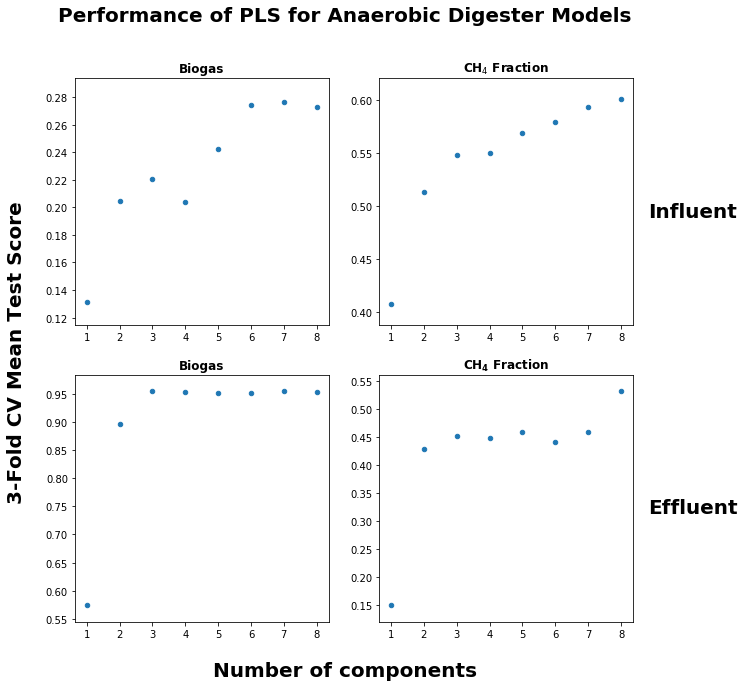

In [75]:
# PLS Comparison
n_estimators = [int(x) for x in np.linspace(1,8,8)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of PLS for Anaerobic Digester Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(n_estimators,In_model.PLS.Biogas.grid.cv_results_['mean_test_score'], s = 20)
ax[1].scatter(n_estimators,In_model.PLS.CH4.grid.cv_results_['mean_test_score'], s = 20)
ax[2].scatter(n_estimators,Out_model.PLS.Biogas.grid.cv_results_['mean_test_score'], s = 20)
ax[3].scatter(n_estimators,Out_model.PLS.CH4.grid.cv_results_['mean_test_score'], s = 20)

titles = ['Biogas', 'CH'+r'$_4$ Fraction', 'Biogas', r'$\mathbf{CH_4}$ Fraction']    
legends = [int(x) for x in np.linspace(1,8,8)] 
legend_properties = {'weight':'bold'}

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

ax[1].set_ylabel('Influent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[1].yaxis.set_label_position('right')
ax[3].set_ylabel('Effluent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[3].yaxis.set_label_position('right')

fig.text(0.031, 0.5,'3-Fold CV Mean Test Score', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of components', ha = 'center', fontsize = 20, fontweight = 'bold')

Text(0.5, 0.05, 'Number of Neighbours')

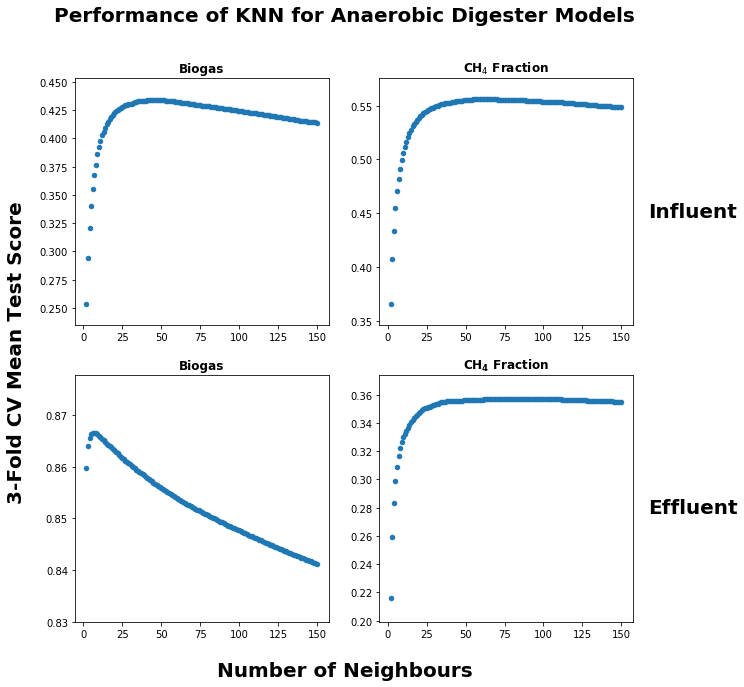

In [76]:
# PLS Comparison
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of KNN for Anaerobic Digester Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(n_estimators,In_model.KNN.Biogas.grid.cv_results_['mean_test_score'], s = 20)
ax[1].scatter(n_estimators,In_model.KNN.CH4.grid.cv_results_['mean_test_score'], s = 20)
ax[2].scatter(n_estimators,Out_model.KNN.Biogas.grid.cv_results_['mean_test_score'], s = 20)
ax[3].scatter(n_estimators,Out_model.KNN.CH4.grid.cv_results_['mean_test_score'], s = 20)

titles = ['Biogas', 'CH'+r'$_4$ Fraction', 'Biogas', r'$\mathbf{CH_4}$ Fraction']    
legends = [int(x) for x in np.linspace(1,7,7)] 
legend_properties = {'weight':'bold'}

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

ax[1].set_ylabel('Influent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[1].yaxis.set_label_position('right')
ax[3].set_ylabel('Effluent', rotation = 0, labelpad = 60, fontweight = 'bold', fontsize = 20)
ax[3].yaxis.set_label_position('right')

fig.text(0.031, 0.5,'3-Fold CV Mean Test Score', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of Neighbours', ha = 'center', fontsize = 20, fontweight = 'bold')

We can now compare the performance of the best predictors on the test set.

In [26]:
dic1 = {'1':In_model,'2': Out_model}
dicall = {}
dic2 = {}
for key in dic1:
    dic2 = {}
    for attr, value in dic1[key].__dict__.items():
        dic2[attr] = {str('Biogas '+key):value.Biogas.RMSE, str('CH4 '+ key):value.CH4.RMSE}
    dicall[key] = dic2

In [27]:
# Number of PLS components

a = [In_model.PLS.Biogas.grid.best_estimator_['clf'].n_components, In_model.PLS.CH4.grid.best_estimator_['clf'].n_components]
b = [Out_model.PLS.Biogas.grid.best_estimator_['clf'].n_components, Out_model.PLS.CH4.grid.best_estimator_['clf'].n_components]

pd.DataFrame(np.vstack((a,b)), index = ['Influent','Effluent'], columns = ['Biogas', r'$\mathbf{CH}_4$'])

,Biogas,$\mathbf{CH}_4$
Influent,7,8
Effluent,7,8


In [28]:
# Number of max features
a = [In_model.RF.Biogas.grid.best_estimator_['clf'].max_features, In_model.RF.CH4.grid.best_estimator_['clf'].max_features]
b = [Out_model.RF.Biogas.grid.best_estimator_['clf'].max_features, Out_model.RF.CH4.grid.best_estimator_['clf'].max_features]

pd.DataFrame(np.vstack((a,b)), index = ['Influent','Effluent'], columns = ['Biogas', r'$\mathbf{CH}_4$'])

,Biogas,$\mathbf{CH}_4$
Influent,4,6
Effluent,6,1


In [29]:
# Number of Neighbors

a = [In_model.KNN.Biogas.grid.best_estimator_['clf'].n_neighbors, In_model.KNN.CH4.grid.best_estimator_['clf'].n_neighbors]
b = [Out_model.KNN.Biogas.grid.best_estimator_['clf'].n_neighbors, Out_model.KNN.CH4.grid.best_estimator_['clf'].n_neighbors]

pd.DataFrame(np.vstack((a,b)), index = ['Influent','Effluent'], columns = ['Biogas', r'$\mathbf{CH}_4$'])

,Biogas,$\mathbf{CH}_4$
Influent,45,61
Effluent,6,68


In [30]:
# Linear regression coefficients and intercept for the influent models of biogas and CH4

a = In_model.linreg.Biogas.grid.best_estimator_['clf'].coef_
a = np.append(a,In_model.linreg.Biogas.grid.best_estimator_['clf'].intercept_)

b = In_model.linreg.CH4.grid.best_estimator_['clf'].coef_
b = np.append(b,In_model.linreg.CH4.grid.best_estimator_['clf'].intercept_)


pd.DataFrame(np.vstack((a,b)), index = ['Biogas',r'$\mathbf{CH}_4$'], columns =  ['Q', 'T', 'TSS', r'$\mathbf{NH_4}$', r'$\mathbf{PO^{3-}_4}$', r'$\mathbf{CO^{2-}_3}$', r'$\mathbf{CH_3COO^-}$','pH', 'Intercept'])


,Q,T,TSS,$\mathbf{NH_4}$,$\mathbf{PO^{3-}_4}$,$\mathbf{CO^{2-}_3}$,$\mathbf{CH_3COO^-}$,pH,Intercept
Biogas,33.971802,-173.289573,-26.117287,29.180264,-50.233902,-123.390612,63.593488,-7.447806,2525.207911
$\mathbf{CH}_4$,-0.000955,0.003681,0.003102,0.012061,-0.003859,0.002459,-0.010064,-0.005564,0.601381


In [31]:
# Linear regression coefficients and intercept for the effluent models of biogas and CH4

a = Out_model.linreg.Biogas.grid.best_estimator_['clf'].coef_
a = np.append(a,Out_model.linreg.Biogas.grid.best_estimator_['clf'].intercept_)

b = Out_model.linreg.CH4.grid.best_estimator_['clf'].coef_
b = np.append(b,Out_model.linreg.CH4.grid.best_estimator_['clf'].intercept_)


pd.DataFrame(np.vstack((a,b)), index = ['Biogas',r'$\mathbf{CH}_4$'], columns =  ['Q', 'T', 'TSS', r'$\mathbf{NH_4}$', r'$\mathbf{PO^{3-}_4}$', r'$\mathbf{CO^{2-}_3}$','pH', 'VFAs', 'Intercept'])



,Q,T,TSS,$\mathbf{NH_4}$,$\mathbf{PO^{3-}_4}$,$\mathbf{CO^{2-}_3}$,pH,VFAs,Intercept
Biogas,-0.066779,-0.034613,6.378231,-6.672592,65.335356,101.684278,-26.268133,192.965997,2525.207911
$\mathbf{CH}_4$,-0.000251,0.000005,0.007782,0.009847,-0.010701,-0.013746,0.003707,-0.002476,0.601381


In [32]:
Model1 = pd.DataFrame.from_dict(dicall['1'], orient='index')
Model2 = pd.DataFrame.from_dict(dicall['2'], orient='index')
result = pd.concat([Model1,Model2], axis = 1)
result = result.reindex(sorted(result.columns), axis=1)
result

,Biogas 1,Biogas 2,CH4 1,CH4 2
linreg,140.316336,29.212263,0.003121,0.003569
PLS,140.105985,29.565010,0.003121,0.003569
KNN,111.230147,44.332209,0.003194,0.003466
RF,94.125156,31.133127,0.003149,0.003411


The above table shows the RMSE on the test set data for the best models chosen through a 3 fold CV approach.
Predicting the biogas production is easier from the output of the reactor than the inlet with these methods, however
predicting the methane content is somewhat consistent across. Overall there are not large discrepancies between the different models

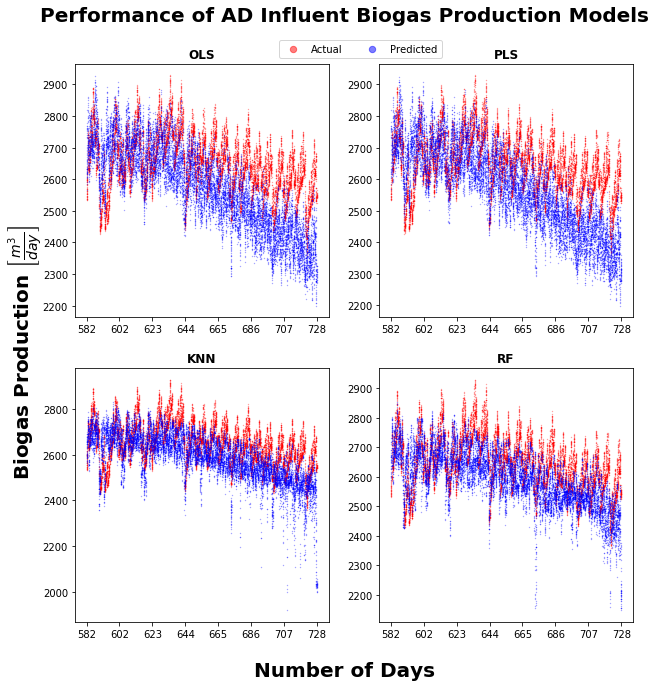

In [71]:
# Digester Model 1 - Biogas prediction
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of AD Influent Biogas Production Models', fontsize = 20, fontweight = 'bold')

ax[0].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, alpha = 0.5, color = 'r')
ax[0].scatter(y_test['Biogas'].index.tolist(), In_model.linreg.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, alpha = 0.5, color = 'r')
ax[1].scatter(y_test['Biogas'].index.tolist(), In_model.PLS.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, alpha = 0.5, color = 'r')
ax[2].scatter(y_test['Biogas'].index.tolist(), In_model.KNN.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, alpha = 0.5, color = 'r')
ax[3].scatter(y_test['Biogas'].index.tolist(), In_model.RF.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')




titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,'Biogas Production '+ r'$ \left[\frac{m^3}{day} \right]$', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test['Biogas'].index.tolist()[0],y_test['Biogas'].index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

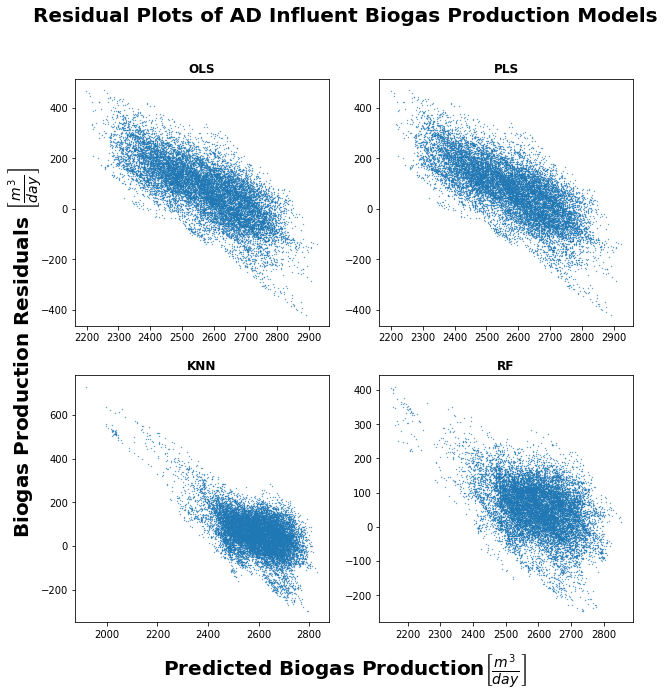

In [72]:
# Digester Model 1 - Biogas residuals
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Residual Plots of AD Influent Biogas Production Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(In_model.linreg.Biogas.predictions, In_model.linreg.Biogas.residuals,  s = 0.1)
ax[1].scatter(In_model.PLS.Biogas.predictions, In_model.PLS.Biogas.residuals, s = 0.1)
ax[2].scatter(In_model.KNN.Biogas.predictions, In_model.KNN.Biogas.residuals, s = 0.1)
ax[3].scatter(In_model.RF.Biogas.predictions, In_model.RF.Biogas.residuals, s = 0.1)


titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,'Biogas Production Residuals '+ r'$ \left[\frac{m^3}{day} \right]$', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Predicted Biogas Production'+ r'$ \left[\frac{m^3}{day} \right]$', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

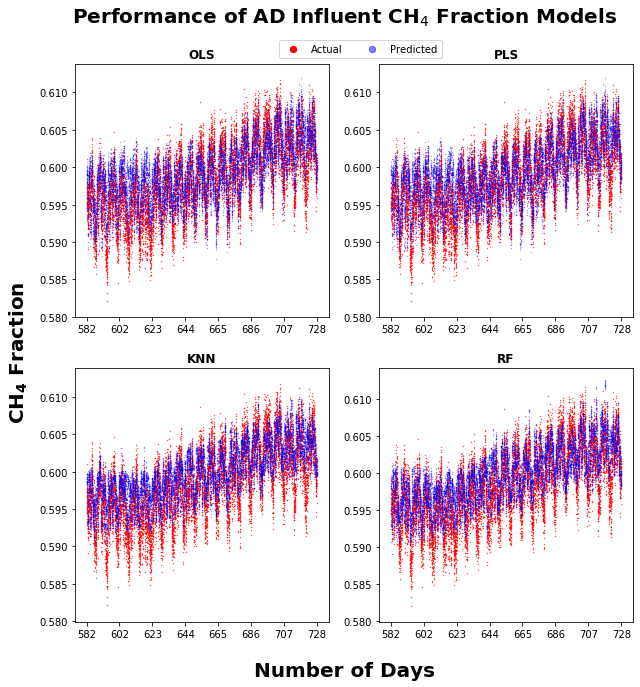

In [70]:
# Biogas Model 1 - CH4% prediction
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Performance of AD Influent CH$_4$ Fraction Models', fontsize = 20, fontweight = 'bold')

ax[0].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[0].scatter(y_test['Biogas'].index.tolist(), In_model.linreg.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[1].scatter(y_test['Biogas'].index.tolist(), In_model.PLS.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[2].scatter(y_test['Biogas'].index.tolist(), In_model.KNN.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[3].scatter(y_test['Biogas'].index.tolist(), In_model.RF.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')




titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,r'$\mathbf{CH_{4}}$ Fraction', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test['Biogas'].index.tolist()[0],y_test['Biogas'].index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

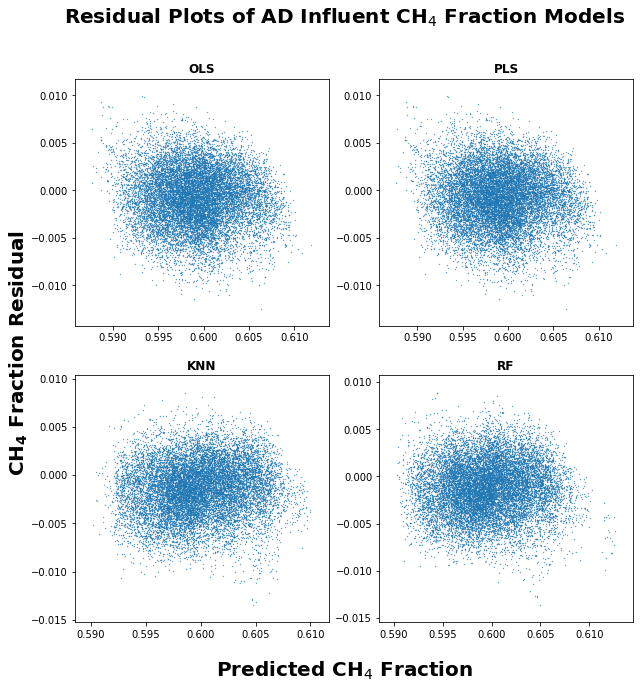

In [69]:
# Digester Model 1 - CH4% residuals
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Residual Plots of AD Influent CH$_4$ Fraction Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(In_model.linreg.CH4.predictions, In_model.linreg.CH4.residuals,  s = 0.1)
ax[1].scatter(In_model.PLS.CH4.predictions, In_model.PLS.CH4.residuals, s = 0.1)
ax[2].scatter(In_model.KNN.CH4.predictions, In_model.KNN.CH4.residuals, s = 0.1)
ax[3].scatter(In_model.RF.CH4.predictions, In_model.RF.CH4.residuals, s = 0.1)


titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,r'$\mathbf{CH_{4}}$ ' + 'Fraction Residual', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Predicted CH'+r'$_4$ '+'Fraction', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

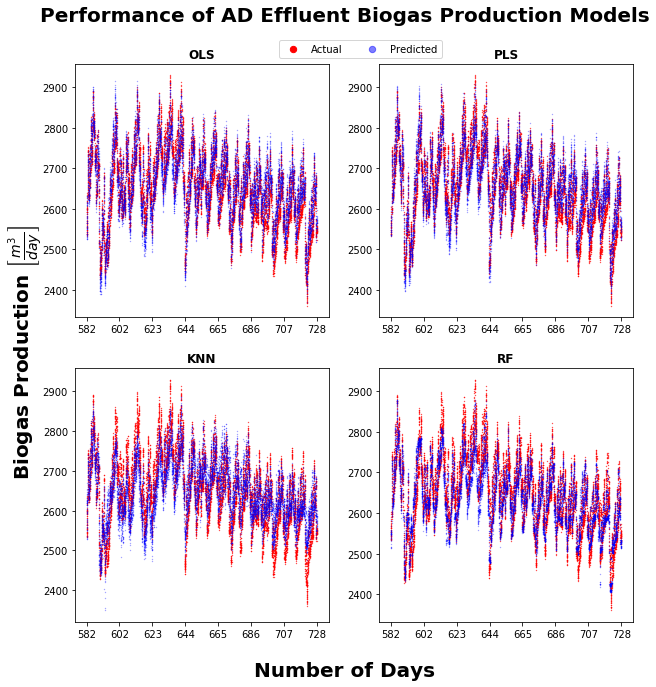

In [68]:
# Biogas Model 2 - Biogas prediction
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Performance of AD Effluent Biogas Production Models', fontsize = 20, fontweight = 'bold')



ax[0].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, color = 'r')
ax[0].scatter(y_test['Biogas'].index.tolist(), Out_model.linreg.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')

ax[1].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, color = 'r')
ax[1].scatter(y_test['Biogas'].index.tolist(), Out_model.PLS.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')

ax[2].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'], s = 0.1, color = 'r')
ax[2].scatter(y_test['Biogas'].index.tolist(), Out_model.KNN.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')

ax[3].scatter(y_test['Biogas'].index.tolist(), y_test['Biogas'],  s = 0.1, color = 'r')
ax[3].scatter(y_test['Biogas'].index.tolist(), Out_model.RF.Biogas.predictions, s = 0.1, alpha = 0.5, color = 'b')




titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,'Biogas Production '+ r'$ \left[\frac{m^3}{day} \right]$', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test['Biogas'].index.tolist()[0],y_test['Biogas'].index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.legend(['Actual', 'Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

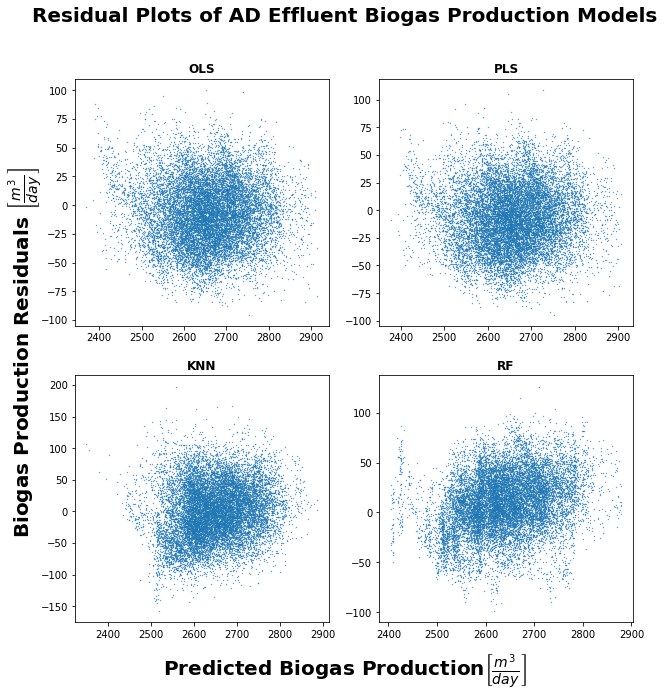

In [67]:
# Digester Model 2 - Biogas residuals
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Residual Plots of AD Effluent Biogas Production Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(Out_model.linreg.Biogas.predictions, Out_model.linreg.Biogas.residuals,  s = 0.1)
ax[1].scatter(Out_model.PLS.Biogas.predictions, Out_model.PLS.Biogas.residuals, s = 0.1)
ax[2].scatter(Out_model.KNN.Biogas.predictions, Out_model.KNN.Biogas.residuals, s = 0.1)
ax[3].scatter(Out_model.RF.Biogas.predictions, Out_model.RF.Biogas.residuals, s = 0.1)


titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,'Biogas Production Residuals '+ r'$ \left[\frac{m^3}{day} \right]$', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Predicted Biogas Production'+ r'$ \left[\frac{m^3}{day} \right]$', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

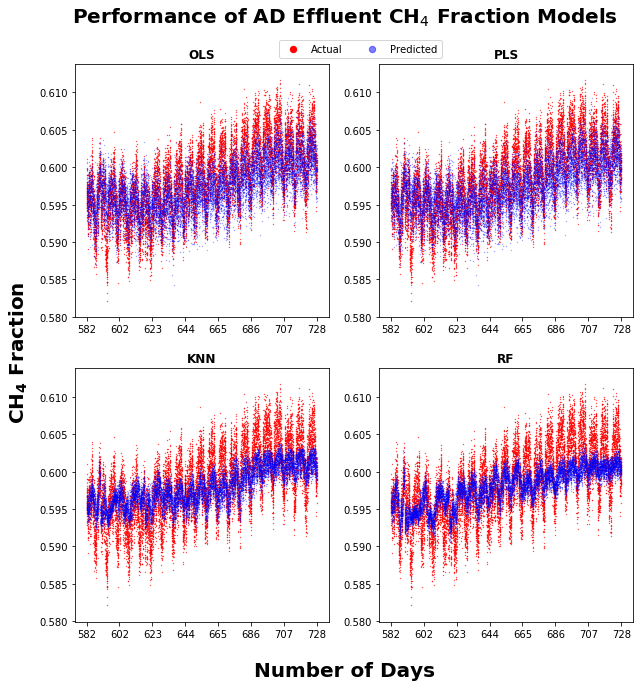

In [65]:
# Biogas Model 2 - CH4% prediction
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle(r'Performance of AD Effluent CH$_4$ Fraction Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[0].scatter(y_test['Biogas'].index.tolist(), Out_model.linreg.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[1].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[1].scatter(y_test['Biogas'].index.tolist(), Out_model.PLS.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[2].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[2].scatter(y_test['Biogas'].index.tolist(), Out_model.KNN.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')
ax[3].scatter(y_test['Biogas'].index.tolist(), y_test[r'$\mathbf{CH_{4}\%}$'], s = 0.1, color = 'r')
ax[3].scatter(y_test['Biogas'].index.tolist(), Out_model.RF.CH4.predictions, s = 0.1, alpha = 0.5, color = 'b')




titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,r'$\mathbf{CH_{4}}$ Fraction', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Number of Days', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_xticks([int(x) for x in np.linspace(y_test['Biogas'].index.tolist()[0],y_test['Biogas'].index.tolist()[-1], 8)])
    ax[i].set_xticklabels([int(x) for x in np.linspace(582,728,8)])
    ax[i].set_title(titles[i], fontweight = 'bold')

fig.legend(['Actual','Predicted'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 7,
          bbox_to_anchor = (0.5,0.9),
          markerscale = 20)
fig.subplots_adjust(top=0.90)

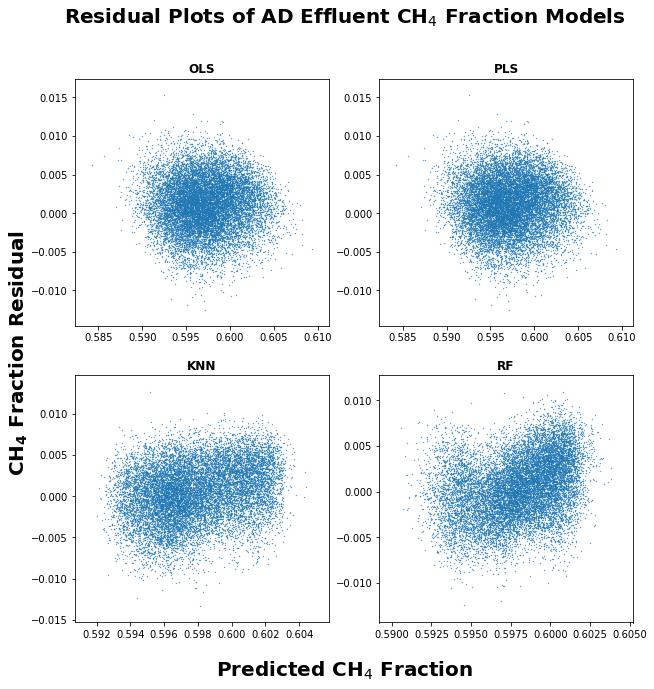

In [66]:
# Digester Model 2 - CH4% residuals
n_estimators = [int(x) for x in np.linspace(2,150,149)]

fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.flatten()

fig.suptitle('Residual Plots of AD Effluent CH$_4$ Fraction Models', fontsize = 20, fontweight = 'bold')


ax[0].scatter(Out_model.linreg.CH4.predictions, Out_model.linreg.CH4.residuals,  s = 0.1)
ax[1].scatter(Out_model.PLS.CH4.predictions, Out_model.PLS.CH4.residuals, s = 0.1)
ax[2].scatter(Out_model.KNN.CH4.predictions, Out_model.KNN.CH4.residuals, s = 0.1)
ax[3].scatter(Out_model.RF.CH4.predictions, Out_model.RF.CH4.residuals, s = 0.1)


titles = ['OLS', 'PLS', 'KNN', 'RF']    



fig.text(0.031, 0.5,r'$\mathbf{CH_{4}}$ Fraction' + ' Residual', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.05,'Predicted CH'+r'$_4$ Fraction', ha = 'center', fontsize = 20, fontweight = 'bold')

for i in range(4):
    ax[i].set_title(titles[i], fontweight = 'bold')

In [41]:
keys = [In_model, Out_model]

Linreg_RMSE = pd.DataFrame()
PLS_RMSE = pd.DataFrame()
KNN_RMSE = pd.DataFrame()
RF_RMSE = pd.DataFrame()

Linreg_MAPE = pd.DataFrame()
PLS_MAPE = pd.DataFrame()
KNN_MAPE = pd.DataFrame()
RF_MAPE = pd.DataFrame()

for key in keys:
    
    a1 = pd.DataFrame({'Biogas': [key.linreg.Biogas.RMSE],r'$\mathbf{CH_{4}\%}$': [key.linreg.CH4.RMSE]})
    a2 = pd.DataFrame({'Biogas': [np.mean(np.abs((y_test['Biogas']-key.linreg.Biogas.predictions)/y_test['Biogas']*100))], 
                      r'$\mathbf{CH_{4}\%}$':[np.mean(np.abs((y_test[r'$\mathbf{CH_{4}\%}$']-key.linreg.CH4.predictions)/y_test[r'$\mathbf{CH_{4}\%}$']*100))]})
    Linreg_RMSE = Linreg_RMSE.append(a1)
    Linreg_MAPE = Linreg_MAPE.append(a2)
    
    b1 = pd.DataFrame({'Biogas': [key.PLS.Biogas.RMSE], r'$\mathbf{CH_{4}\%}$': [key.PLS.CH4.RMSE]})
    b2 = pd.DataFrame({'Biogas': [np.mean(np.abs((y_test['Biogas']-key.PLS.Biogas.predictions.ravel())/y_test['Biogas']*100))], 
                      r'$\mathbf{CH_{4}\%}$':[np.mean(np.abs((y_test[r'$\mathbf{CH_{4}\%}$']-key.PLS.CH4.predictions.ravel())/y_test[r'$\mathbf{CH_{4}\%}$']*100))]})
    PLS_RMSE = PLS_RMSE.append(b1)
    PLS_MAPE = PLS_MAPE.append(b2)
    
    c1 = pd.DataFrame({'Biogas': [key.KNN.Biogas.RMSE], r'$\mathbf{CH_{4}\%}$': [key.KNN.CH4.RMSE]})
    c2 = pd.DataFrame({'Biogas': [np.mean(np.abs((y_test['Biogas']-key.KNN.Biogas.predictions.ravel())/y_test['Biogas']*100))], 
                      r'$\mathbf{CH_{4}\%}$':[np.mean(np.abs((y_test[r'$\mathbf{CH_{4}\%}$']-key.KNN.CH4.predictions.ravel())/y_test[r'$\mathbf{CH_{4}\%}$']*100))]})
    KNN_RMSE = KNN_RMSE.append(c1)
    KNN_MAPE = KNN_MAPE.append(c2)
    
    d1 = pd.DataFrame({'Biogas': [key.RF.Biogas.RMSE], r'$\mathbf{CH_{4}\%}$': [key.RF.CH4.RMSE]})
    d2 = pd.DataFrame({'Biogas': [np.mean(np.abs((y_test['Biogas']-key.RF.Biogas.predictions.ravel())/y_test['Biogas']*100))], 
                      r'$\mathbf{CH_{4}\%}$':[np.mean(np.abs((y_test[r'$\mathbf{CH_{4}\%}$']-key.RF.CH4.predictions.ravel())/y_test[r'$\mathbf{CH_{4}\%}$']*100))]})
    RF_RMSE = RF_RMSE.append(d1)
    RF_MAPE = RF_MAPE.append(d2)

Index = ['Influent', 'Effluent']


Linreg_RMSE.index = Index
PLS_RMSE.index = Index
KNN_RMSE.index = Index
RF_RMSE.index = Index

Linreg_MAPE.index = Index
PLS_MAPE.index = Index
KNN_MAPE.index = Index
RF_MAPE.index = Index

In [42]:
Linreg_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,140.316336,0.003121
Effluent,29.212263,0.003569


In [43]:
PLS_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,140.105985,0.003121
Effluent,29.565010,0.003569


In [44]:
KNN_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,111.230147,0.003194
Effluent,44.332209,0.003466


In [45]:
RF_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,94.125156,0.003149
Effluent,31.133127,0.003411


In [46]:
RF_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,94.125156,0.003149
Effluent,31.133127,0.003411


In [47]:
np.mean(y_test)

Biogas                 2648.113731
$\mathbf{CH_{4}\%}$       0.598365
dtype: float64

In [51]:
np.min(y_test)

Biogas                 2360.264087
$\mathbf{CH_{4}\%}$       0.582069
dtype: float64

In [52]:
np.max(y_test)

Biogas                 2928.711950
$\mathbf{CH_{4}\%}$       0.611651
dtype: float64

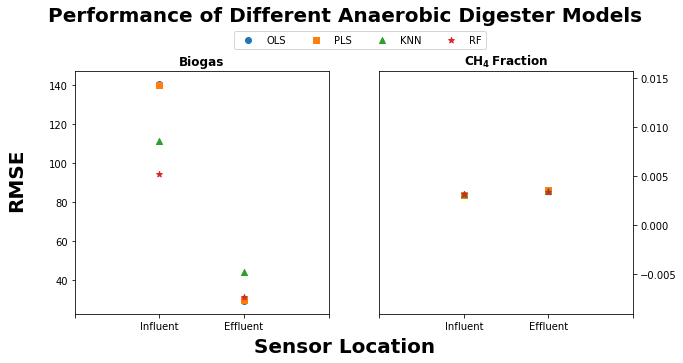

In [77]:
Model_RMSES = [Linreg_RMSE, PLS_RMSE, KNN_RMSE, RF_RMSE]
variables = ['Biogas', r'$\mathbf{CH_{4}\%}$']

fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Performance of Different Anaerobic Digester Models', fontsize = 20, fontweight = 'bold')
ax = ax.ravel()

for i in range(2):
    ax[i].scatter([1,2],Linreg_RMSE[variables[i]])
    ax[i].scatter([1,2],PLS_RMSE[variables[i]], marker = 's')
    ax[i].scatter([1,2],KNN_RMSE[variables[i]], marker = '^')
    ax[i].scatter([1,2],RF_RMSE[variables[i]],marker = '*')
    ax[i].set_xticks([0,1,2,3])
    ax[i].set_xticklabels(['','Influent', 'Effluent',''])
    ax[i].set_title(variables[i], fontweight = 'bold')
    


ax[1].yaxis.tick_right()
ax[1].set_title(r'$\mathbf{CH_4} \, \mathbf{Fraction}$')

fig.text(0.031, 0.5,'RMSE', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.02,'Sensor Location', ha = 'center', fontsize = 20, fontweight = 'bold')

fig.legend(['OLS', 'PLS', 'KNN', 'RF'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 4,
          bbox_to_anchor = (0.5,0.925))
fig.subplots_adjust(top=0.8)

In [49]:
Linreg_RMSE[variables[1]]

Influent    0.003121
Effluent    0.003569
Name: $\mathbf{CH_{4}\%}$, dtype: float64

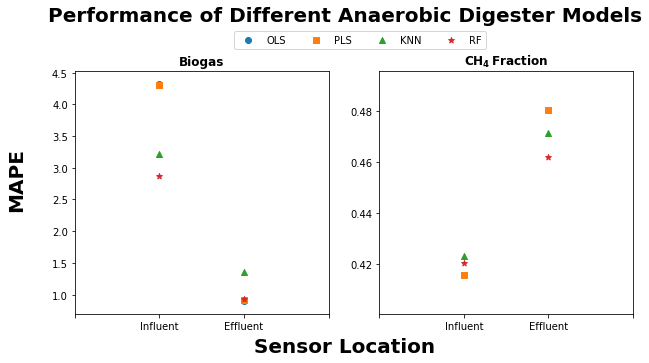

In [78]:
Model_MAPEs = [Linreg_MAPE, PLS_MAPE, KNN_MAPE, RF_MAPE]
variables = ['Biogas', r'$\mathbf{CH_{4}\%}$']

fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Performance of Different Anaerobic Digester Models', fontsize = 20, fontweight = 'bold')
ax = ax.ravel()

for i in range(2):
    ax[i].scatter([1,2],Linreg_MAPE[variables[i]])
    ax[i].scatter([1,2],PLS_MAPE[variables[i]], marker = 's')
    ax[i].scatter([1,2],KNN_MAPE[variables[i]], marker = '^')
    ax[i].scatter([1,2],RF_MAPE[variables[i]],marker = '*')
    ax[i].set_xticks([0,1,2,3])
    ax[i].set_xticklabels(['','Influent', 'Effluent',''])
    ax[i].set_title(variables[i], fontweight = 'bold')

ax[1].set_title(r'$\mathbf{CH_{4}} \, \mathbf{Fraction}$')  

fig.text(0.031, 0.5,'MAPE', va = 'center', fontsize = 20, rotation = 'vertical', fontweight = 'bold')
fig.text(0.5, 0.02,'Sensor Location', ha = 'center', fontsize = 20, fontweight = 'bold')

fig.legend(['OLS', 'PLS', 'KNN', 'RF'],
          loc = "upper center",
          borderaxespad = 0.1,
          ncol = 4,
          bbox_to_anchor = (0.5,0.925))
fig.subplots_adjust(top=0.8)

In [55]:



Linreg_RMSE.to_csv('Initial_OLS_RMSE_AD.csv')
PLS_RMSE.to_csv('Initial_PLS_RMSE_AD.csv')
KNN_RMSE.to_csv('Initial_KNN_RMSE_AD.csv')
RF_RMSE.to_csv('Initial_RF_RMSE_AD.csv')



In [73]:
PLS_MAPE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,4.309181,0.415619
Effluent,0.910184,0.480131


In [56]:
Linreg_RMSE

,Biogas,$\mathbf{CH_{4}\%}$
Influent,140.316336,0.003121
Effluent,29.212263,0.003569
